In [2]:
import os
import pandas as pd
from PIL import Image
import torch
import kagglehub
from pathlib import Path
from tqdm.auto import tqdm
import wandb

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### W&B setup (Colab-safe)

- Set `WANDB_API_KEY` in the environment for automatic login.

- If no key is present or login fails, we auto-switch to offline mode so runs still proceed.

- You can also manually set `USE_WANDB = False` to skip logging entirely.


In [3]:
# W&B login via built-in prompt (asks for key if not set)
USE_WANDB = True
if USE_WANDB:
    try:
        wandb.login(relogin=True, force=True)
        print("wandb: logged in via wandb.login prompt")
    except Exception as e:
        print(f"wandb login prompt failed ({e}); going offline")
        os.environ["WANDB_MODE"] = "offline"
        USE_WANDB = False
else:
    print("wandb disabled; skipping login prompt.")


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\matej\_netrc
wandb: Currently logged in as: xherzog (xherzog-fiit-stu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: logged in via wandb.login prompt


# EDA

In [4]:
# Prefer Intel XPU if present, else CUDA, else CPU

if hasattr(torch, "xpu") and torch.xpu.is_available():

    device = torch.device("xpu")

elif torch.cuda.is_available():

    device = torch.device("cuda")

else:

    device = torch.device("cpu")



print(f"Using device: {device}")

if device.type == "cuda":

    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

elif device.type == "xpu":

    try:

        print(f"XPU Name: {torch.xpu.get_device_name(0)}")

    except Exception:

        pass



Using device: xpu
XPU Name: Intel(R) Arc(TM) 140V GPU (16GB)


In [5]:
import random
import numpy as np


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)


SEED = 42
set_seed(SEED)
print(f"Seeds set to {SEED}")


Seeds set to 42


In [6]:
path = Path(kagglehub.dataset_download("alessiocorrado99/animals10")) / "raw-img"

print("Path to dataset files:", path)

Path to dataset files: C:\Users\matej\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img


Animals type

In [7]:
clases = os.listdir(path)
print(clases)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Num of photos in each folder

In [8]:
print(f"{'Class Name':<20} | {'Count'}")
print("-" * 30)
for cl in clases:
    folder_path = path / cl
    count = len(os.listdir(folder_path))
    print(f"{cl:<20} | {count}")

Class Name           | Count
------------------------------
cane                 | 4863
cavallo              | 2623
elefante             | 1446
farfalla             | 2112
gallina              | 3098
gatto                | 1668
mucca                | 1866
pecora               | 1820
ragno                | 4821
scoiattolo           | 1862


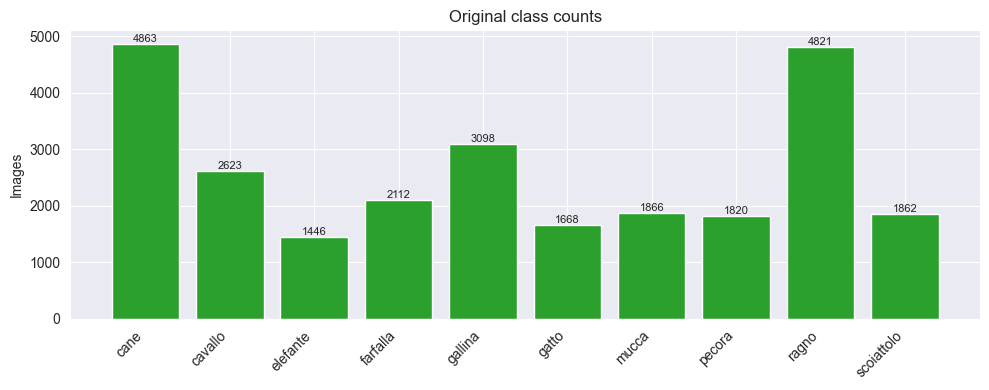

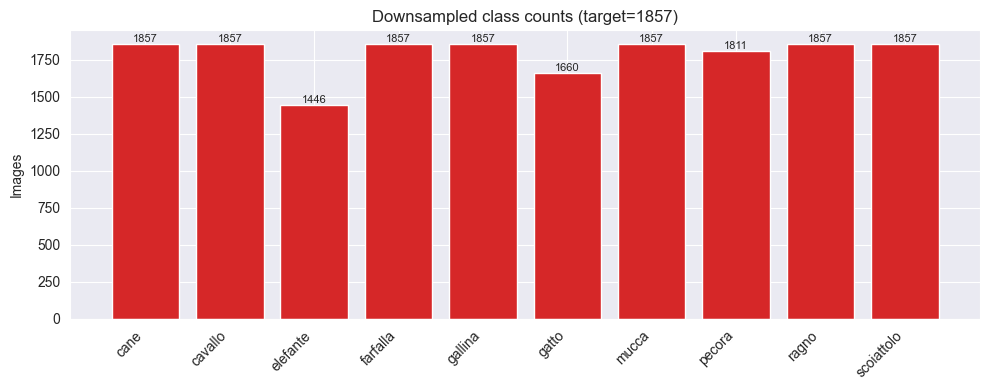

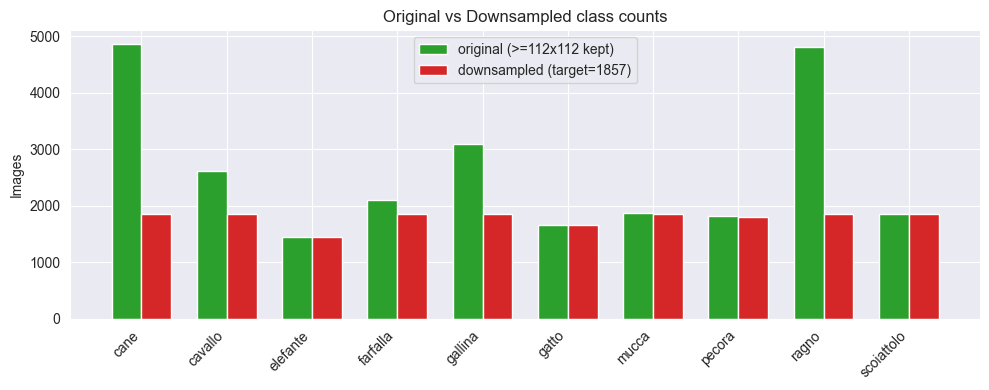

Dropped 58 images smaller than 112x112.
Using target count 1857 (4th lowest post-filter).
Total images after downsampling: 17916


In [9]:
# Balance dataset: drop tiny images (<112x112), then downsample to 4th-lowest class size with visuals
import numpy as np

green_color = "#2ca02c"
red_color = "#d62728"
rng = random.Random(SEED)

# Collect per-class file lists
class_files = {}
for cl in clases:
    folder = path / cl
    if not folder.is_dir():
        continue
    class_files[cl] = [folder / f for f in os.listdir(folder)]

original_counts = {c: len(v) for c, v in class_files.items()}

# Filter out very small images
filtered_class_files = {}
dropped_small = 0
for cl, file_list in class_files.items():
    kept = []
    for fp in file_list:
        try:
            with Image.open(fp) as img:
                w, h = img.size
                if w < 112 or h < 112:
                    dropped_small += 1
                    continue
            kept.append(fp)
        except Exception:
            continue
    filtered_class_files[cl] = kept

filtered_counts = {c: len(v) for c, v in filtered_class_files.items()}

# Determine downsample target = 4th lowest count (post-filter)
sorted_counts = sorted(filtered_counts.values())
if len(sorted_counts) >= 4:
    target_count = sorted_counts[3]
else:
    target_count = min(sorted_counts) if sorted_counts else 0

balanced_class_files = {}
for cl, file_list in filtered_class_files.items():
    if len(file_list) > target_count:
        balanced_class_files[cl] = rng.sample(file_list, target_count)
    else:
        balanced_class_files[cl] = list(file_list)

downsampled_counts = {c: len(v) for c, v in balanced_class_files.items()}

# Plot helpers

def plot_counts(counts, title, color):
    classes = sorted(counts.keys())
    values = [counts[c] for c in classes]
    plt.figure(figsize=(10, 4))
    bars = plt.bar(classes, values, color=color)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Images")
    plt.title(title)
    for b, val in zip(bars, values):
        plt.text(b.get_x() + b.get_width() / 2, b.get_height(), str(val), ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

plot_counts(original_counts, "Original class counts", green_color)
plot_counts(downsampled_counts, f"Downsampled class counts (target={target_count})", red_color)

# Combined comparison plot
classes_sorted = sorted(original_counts.keys())
x = np.arange(len(classes_sorted))
orig_vals = [original_counts.get(c, 0) for c in classes_sorted]
down_vals = [downsampled_counts.get(c, 0) for c in classes_sorted]
width = 0.35
plt.figure(figsize=(10, 4))
plt.bar(x - width / 2, orig_vals, width, color=green_color, label="original (>=112x112 kept)")
plt.bar(x + width / 2, down_vals, width, color=red_color, label=f"downsampled (target={target_count})")
plt.xticks(x, classes_sorted, rotation=45, ha='right')
plt.ylabel("Images")
plt.title("Original vs Downsampled class counts")
plt.legend()
plt.tight_layout()
plt.show()

# Build balanced file/label lists for downstream splits
class_names = sorted(balanced_class_files.keys())
class_to_idx = {c: i for i, c in enumerate(class_names)}
files = []
labels = []
for cl in class_names:
    for fp in balanced_class_files[cl]:
        files.append(str(fp))
        labels.append(class_to_idx[cl])

print(f"Dropped {dropped_small} images smaller than 112x112.")
print(f"Using target count {target_count} (4th lowest post-filter).")
print(f"Total images after downsampling: {len(files)}")

See what we have in dataset

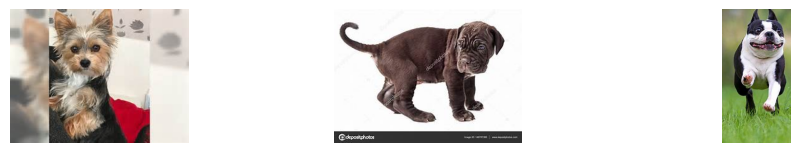

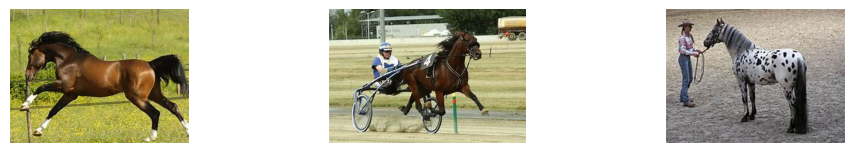

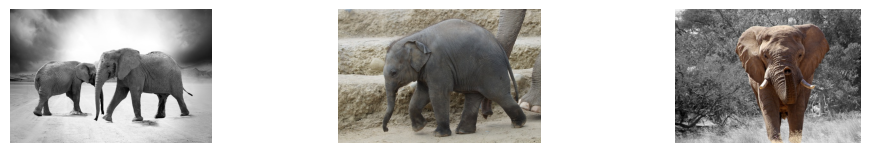

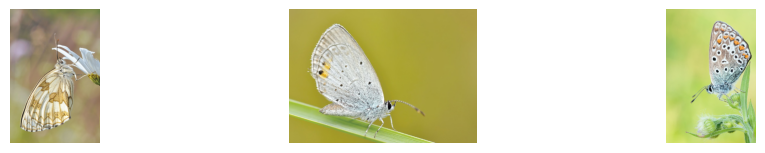

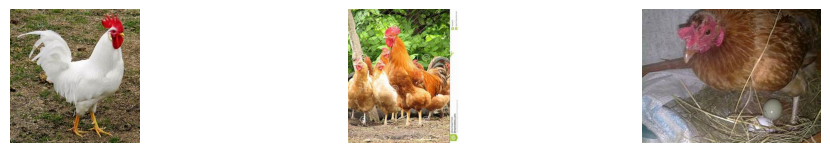

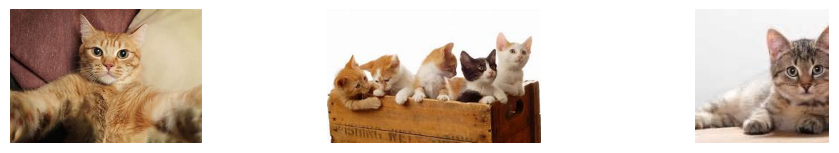

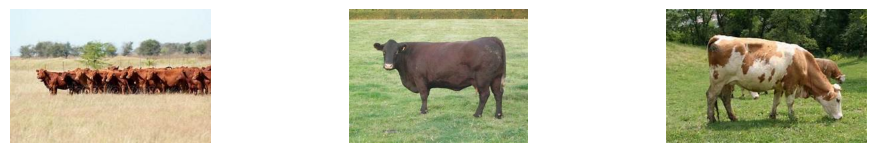

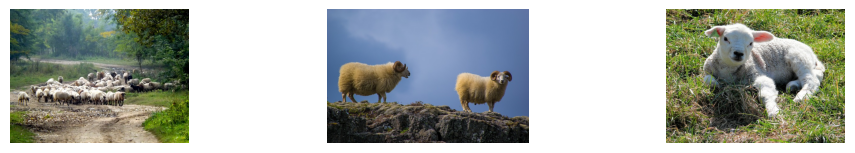

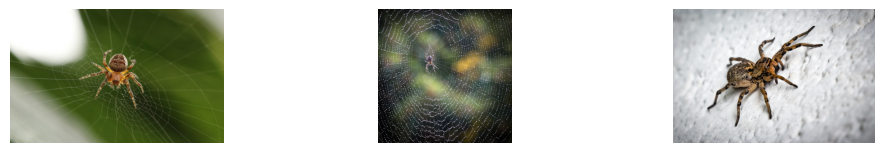

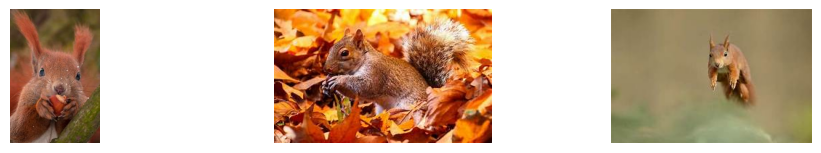

In [10]:
for cl in clases:
    n=3
    plt.figure(figsize=(12, 8))
    a = path / cl
    imgs = os.listdir(a)
    i=1
    for _ in range(n):
        img_path = a / imgs[_]
        img = Image.open(img_path)

        plt.subplot(4, n, i)
        plt.imshow(img)
        plt.axis("off")
        i += 1

Analyze avg size

In [11]:
print(f"{'Class':<20} | {'Min W':<6} | {'Max W':<6} | {'Avg W':<8} | {'Min H':<6} | {'Max H':<6} | {'Avg H':<8}")
print("-" * 80)

# Ensure unique classes and sort them
unique_clases = sorted(list(set(clases)))

for cl in unique_clases:
    folder_path = path / cl
    widths = []
    heights = []

    # Skip if not a directory
    if not folder_path.is_dir():
        continue

    # Get all images in the class folder
    try:
        imgs = os.listdir(folder_path)
    except Exception:
        continue

    for im_name in imgs:
        img_path = folder_path / im_name
        try:
            with Image.open(img_path) as im:
                w, h = im.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            # print(f"Error reading {img_path}: {e}")
            continue

    if widths and heights:
        min_w = min(widths)
        max_w = max(widths)
        avg_w = sum(widths) / len(widths)

        min_h = min(heights)
        max_h = max(heights)
        avg_h = sum(heights) / len(heights)

        print(f"{cl:<20} | {min_w:<6} | {max_w:<6} | {avg_w:<8.1f} | {min_h:<6} | {max_h:<6} | {avg_h:<8.1f}")
    else:
        print(f"{cl:<20} | No images found or error reading images")

Class                | Min W  | Max W  | Avg W    | Min H  | Max H  | Avg H   
--------------------------------------------------------------------------------
cane                 | 109    | 300    | 283.6    | 101    | 300    | 241.1   
cavallo              | 60     | 300    | 287.9    | 57     | 300    | 233.5   
elefante             | 189    | 640    | 377.6    | 115    | 640    | 274.9   
farfalla             | 65     | 640    | 364.5    | 64     | 640    | 280.4   
gallina              | 82     | 300    | 288.3    | 95     | 300    | 239.4   
gatto                | 107    | 6720   | 473.2    | 75     | 6000   | 364.6   
mucca                | 120    | 300    | 294.2    | 86     | 300    | 212.7   
pecora               | 107    | 640    | 363.0    | 71     | 640    | 263.4   
ragno                | 88     | 640    | 311.1    | 80     | 640    | 247.8   
scoiattolo           | 127    | 300    | 287.8    | 97     | 300    | 224.6   


In [12]:
# Analyze Image Channels
modes = {}
channels_count = {}

print("Analyzing image modes and channels")
for cl in clases:
    folder = path / cl
    for img_name in os.listdir(folder):
        img_path = folder / img_name
        try:
            with Image.open(img_path) as img:
                # Count modes (RGB, L, CMYK, etc.)
                modes[img.mode] = modes.get(img.mode, 0) + 1
                # Count channels
                c = len(img.getbands())
                channels_count[c] = channels_count.get(c, 0) + 1
        except:
            pass

print("Image Modes:", modes)
print("Channel Counts:", channels_count)

if 1 in channels_count or 4 in channels_count:
    print("\nNote: Dataset contains images with different channel counts.")
    print("We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.")
else:
    print("\nAll images are already 3 channels (RGB).")

Analyzing image modes and channels
Image Modes: {'RGB': 26128, 'RGBA': 49, 'L': 1, 'CMYK': 1}
Channel Counts: {3: 26128, 4: 50, 1: 1}

Note: Dataset contains images with different channel counts.
We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.


Analyze if RGB images are truly colorful or grayscale-like

In [13]:
# Analyze color distribution in images
# Check if RGB images are truly colorful or essentially grayscale

import numpy as np

def analyze_color_info(img):
    """
    Analyze if an image is truly colorful or grayscale-like.
    Returns metrics about color saturation and channel differences.
    """
    img_array = np.array(img.convert("RGB"))

    # Calculate channel-wise statistics
    r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]

    # Check if channels are similar (grayscale-like)
    # If R ≈ G ≈ B for all pixels, image is grayscale
    rg_diff = np.abs(r.astype(float) - g.astype(float)).mean()
    rb_diff = np.abs(r.astype(float) - b.astype(float)).mean()
    gb_diff = np.abs(g.astype(float) - b.astype(float)).mean()

    avg_channel_diff = (rg_diff + rb_diff + gb_diff) / 3

    # Calculate color saturation using HSV-like approach
    max_channel = np.maximum(np.maximum(r, g), b).astype(float)
    min_channel = np.minimum(np.minimum(r, g), b).astype(float)

    # Saturation: difference between max and min channel
    saturation = np.where(max_channel > 0, (max_channel - min_channel) / max_channel, 0)
    avg_saturation = saturation.mean()

    return avg_channel_diff, avg_saturation

print("Analyzing color characteristics per class...")
print(f"{'Class':<20} | {'Colorful':<10} | {'Grayscale-like':<15} | {'Avg Channel Diff':<18} | {'Avg Saturation':<15}")
print("-" * 90)

unique_clases = sorted(list(set(clases)))

for cl in unique_clases:
    folder_path = path / cl

    if not folder_path.is_dir():
        continue

    colorful_count = 0
    grayscale_like_count = 0
    total_channel_diff = 0
    total_saturation = 0
    valid_images = 0

    imgs = os.listdir(folder_path)

    for im_name in imgs:
        img_path = folder_path / im_name
        try:
            with Image.open(img_path) as im:
                channel_diff, saturation = analyze_color_info(im)
                total_channel_diff += channel_diff
                total_saturation += saturation
                valid_images += 1

                # Threshold: if avg channel difference < 5, consider grayscale-like
                if channel_diff < 5:
                    grayscale_like_count += 1
                else:
                    colorful_count += 1
        except Exception:
            continue

    if valid_images > 0:
        avg_diff = total_channel_diff / valid_images
        avg_sat = total_saturation / valid_images
        print(f"{cl:<20} | {colorful_count:<10} | {grayscale_like_count:<15} | {avg_diff:<18.2f} | {avg_sat:<15.4f}")

print("\nNote: Grayscale-like = RGB images where R ≈ G ≈ B (avg channel diff < 5)")
print("Saturation: 0 = no color, 1 = fully saturated")

Analyzing color characteristics per class...
Class                | Colorful   | Grayscale-like  | Avg Channel Diff   | Avg Saturation 
------------------------------------------------------------------------------------------


C:\Users\matej\AppData\Local\Temp\ipykernel_20104\3893971965.py:29: RuntimeWarning: invalid value encountered in divide
  saturation = np.where(max_channel > 0, (max_channel - min_channel) / max_channel, 0)


cane                 | 4663       | 200             | 24.83              | 0.3060         
cavallo              | 2566       | 57              | 25.28              | 0.3236         
elefante             | 1381       | 65              | 23.85              | 0.2933         
farfalla             | 2083       | 29              | 37.49              | 0.4510         
gallina              | 3050       | 48              | 24.45              | 0.3087         
gatto                | 1514       | 154             | 21.09              | 0.2663         
mucca                | 1841       | 25              | 28.81              | 0.3628         
pecora               | 1790       | 30              | 27.52              | 0.3494         
ragno                | 4517       | 304             | 28.29              | 0.3336         
scoiattolo           | 1842       | 20              | 25.94              | 0.3393         

Note: Grayscale-like = RGB images where R ≈ G ≈ B (avg channel diff < 5)
Saturation: 0 = 

In [14]:
# Use balanced, size-filtered, downsampled dataset prepared earlier
print("Loading preprocessed balanced dataset (size-filtered and downsampled).")
print(f"Total images loaded: {len(files)}")
print(f"Total classes: {len(class_names)}")
print(f"Class mapping: {class_to_idx}")

Loading preprocessed balanced dataset (size-filtered and downsampled).
Total images loaded: 17916
Total classes: 10
Class mapping: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}


In [15]:
print("Splitting dataset into Train / Val / Test sets...")
train_files, temp_files, train_labels, temp_labels = train_test_split(
    files, labels,
    test_size=0.30,
    stratify=labels,
    shuffle=True,
    random_state=42
 )

# Split remaining 30% into validation and test (15% / 15%)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels,
    test_size=0.50,
    stratify=temp_labels,
    shuffle=True,
    random_state=42
 )

print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Testing samples: {len(test_files)}")

Splitting dataset into Train / Val / Test sets...
Training samples: 12541
Validation samples: 2687
Testing samples: 2688


In [16]:
#Budeme vyuzivat accuracy a f1

In [17]:
import torch

from torchvision import datasets, transforms

from torch.utils.data import DataLoader

IS_COLAB = "COLAB_GPU" in os.environ

MAX_WORKERS = os.cpu_count() or 2

ALLOW_MULTIPROC = os.environ.get("ALLOW_MULTIPROC_DATALOADER", "0") == "1"

# Colab warns above 2 workers; keep it small there. Otherwise allow up to 4 on GPU.
if IS_COLAB:
    NUM_WORKERS = 2
elif device.type == "cuda" or device.type == "xpu":
    NUM_WORKERS = min(4, MAX_WORKERS)
else:
    NUM_WORKERS = 0

# Notebook-safe default: force single-process loading to avoid worker shutdown AssertionError.
if not ALLOW_MULTIPROC:
    NUM_WORKERS = 0

PIN_MEMORY = device.type == "cuda" and NUM_WORKERS > 0

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(path, transform=transform)

loader = DataLoader(
    dataset,
    batch_size=64,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

sum_ = torch.zeros(3, dtype=torch.double)
sum_sq = torch.zeros(3, dtype=torch.double)
total_pixels = 0

for images, _ in loader:
    b, c, h, w = images.shape
    num_pixels_in_batch = b * h * w
    sum_ += images.sum(dim=[0, 2, 3]).double()
    sum_sq += (images ** 2).sum(dim=[0, 2, 3]).double()
    total_pixels += num_pixels_in_batch

mean_calculated = sum_ / total_pixels
var = (sum_sq / total_pixels) - (mean_calculated ** 2)
std_calculated = torch.sqrt(var)

print("Mean:", mean_calculated.tolist())
print("Std: ", std_calculated.tolist())

Mean: [0.5177037193957041, 0.5002956887405993, 0.41255208682321987]
Std:  [0.2659483343247254, 0.26099434302033075, 0.2785206766283863]


In [18]:
# Define training transformations with augmentation
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels (R, G, B)
    transforms.Resize((224, 224)),                 # Resize to consistent size
    transforms.RandomHorizontalFlip(p=0.5),        # Data Augmentation: Flip
    #transforms.RandomRotation(5),                  # Data Augmentation: Rotate
    transforms.ColorJitter(                        # Data Augmentation: Color
        brightness=0.15,
        contrast=0.15
    ),
    transforms.ToTensor(),                         # Convert to Tensor (0-1 range)
    transforms.Normalize(                          # Normalize to range [-1, 1]
        # mean = [0.517707626799793, 0.5003007536238897, 0.4125557296095215],
        # std = [0.26413124327703913, 0.25914410756442957, 0.27683583555842795]
        mean = mean_calculated.tolist(),
        std = std_calculated.tolist()

    )
])
print("Training transforms defined.")

Training transforms defined.


Visualizing Training Augmentations:


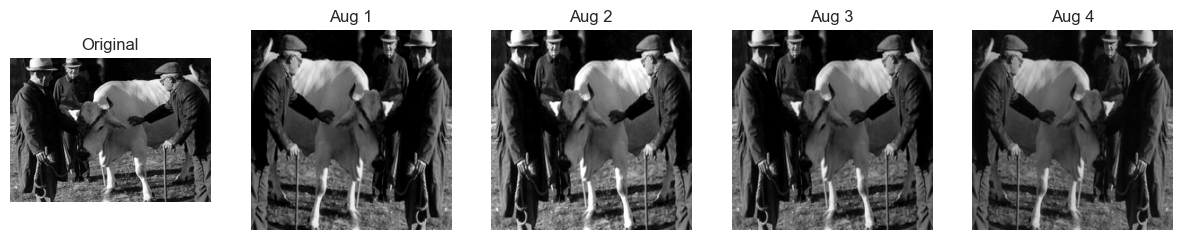

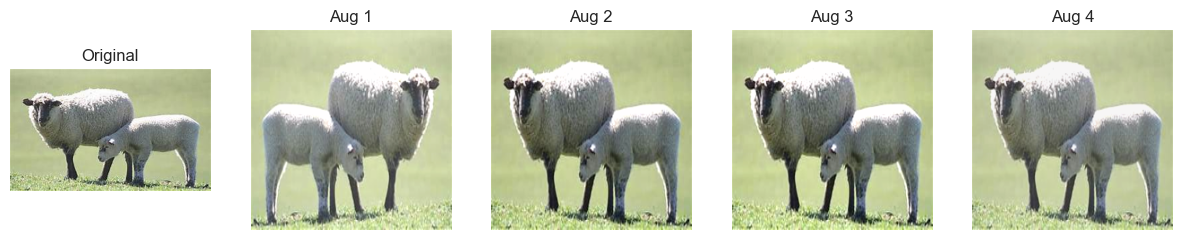

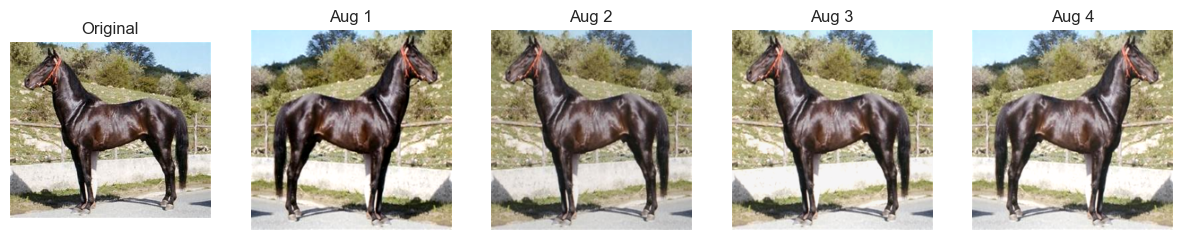

In [19]:
# Visualization of Augmentations
import numpy as np
import random

def visualize_augmentations(files, transform, n_samples=3):
    """
    Visualizes original images and their augmented versions.
    """
    # Select random files
    sample_files = random.sample(files, n_samples)

    for img_path in sample_files:
        # Load original
        original_img = Image.open(img_path)

        # Apply transform multiple times to see variations
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))

        # Show original
        axes[0].imshow(original_img)
        axes[0].set_title("Original")
        axes[0].axis('off')

        mean = np.array(mean_calculated.tolist())
        std = np.array(std_calculated.tolist())

        for i in range(1, 5):
            # Apply transform
            aug_tensor = transform(original_img)

            # Un-normalize and convert to numpy for display
            aug_img = aug_tensor.permute(1, 2, 0).numpy()
            aug_img = (aug_img * std) + mean
            aug_img = np.clip(aug_img, 0, 1)

            axes[i].imshow(aug_img)
            axes[i].set_title(f"Aug {i}")
            axes[i].axis('off')
        plt.show()

print("Visualizing Training Augmentations:")
visualize_augmentations(train_files, train_transform)


In [20]:
# Define test transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels
    transforms.Resize((224, 224)),                 # Resize to consistent size
    transforms.ToTensor(),                         # Convert to Tensor
    transforms.Normalize(                          # Normalize to range [-1, 1]
        mean_calculated,
        std_calculated
    )
])
print("Test transforms defined.")

Test transforms defined.


In [21]:
class AnimalDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

# Initialize Datasets
print("Initializing Datasets...")
train_dataset = AnimalDataset(train_files, train_labels, transform=train_transform)
val_dataset = AnimalDataset(val_files, val_labels, transform=test_transform)
test_dataset = AnimalDataset(test_files, test_labels, transform=test_transform)

# Initialize DataLoaders
BATCH_SIZE = 32
print(f"Initializing DataLoaders with batch size {BATCH_SIZE} and {NUM_WORKERS} workers...")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

print("Data preparation complete.")


Initializing Datasets...
Initializing DataLoaders with batch size 32 and 0 workers...
Data preparation complete.


Visualizing samples from Test Dataset (Preprocessed)...


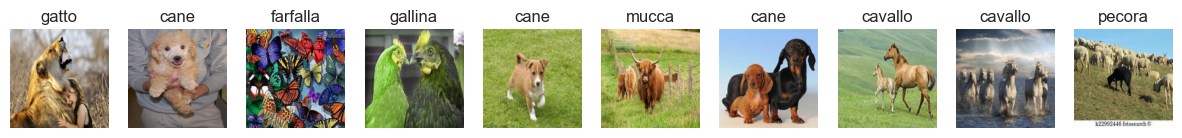

In [22]:
# Visualize Test Data
print("Visualizing samples from Test Dataset (Preprocessed)...")

def visualize_dataset_samples(dataset, class_names, n_samples=5):
    indices = random.sample(range(len(dataset)), n_samples)

    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))

    mean = np.array(mean_calculated.tolist())
    std = np.array(std_calculated.tolist())

    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        # Denormalize for visualization
        img_display = image.permute(1, 2, 0).numpy()
        img_display = (img_display * std) + mean
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.show()

visualize_dataset_samples(test_dataset, class_names, 10)


# CNN Model Architecture

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, cfg):
        super().__init__()

        k = cfg.get("kernel", 3)
        s = cfg.get("stride", 1)
        p = cfg.get("padding", 1)

        use_bn = cfg.get("use_batchnorm", False)
        use_do = cfg.get("use_dropout", False)
        dr = cfg.get("dropout_rate", 0.3)
        bottleneck = cfg.get("use_bottleneck", False)

        layers = []

        if bottleneck:
            mid = out_ch // 4

            layers += [
                nn.Conv2d(in_ch, mid, kernel_size=1),
                nn.BatchNorm2d(mid) if use_bn else nn.Identity(),
                nn.ReLU(),
                nn.Conv2d(mid, mid, kernel_size=k, stride=s, padding=p),
                nn.BatchNorm2d(mid) if use_bn else nn.Identity(),
                nn.ReLU(),
                nn.Conv2d(mid, out_ch, kernel_size=1),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity(),
            ]
        else:
            layers += [
                nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity(),
                nn.ReLU(),
            ]

        if use_do:
            layers += [nn.Dropout2d(dr)]

        self.block = nn.Sequential(*layers)

        needs_proj = (in_ch != out_ch) or (s != 1)
        self.proj = (
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=s)
            if needs_proj
            else nn.Identity()
        )
        self.use_skip = cfg.get("use_skip_connections", False)

    def forward(self, x):
        out = self.block(x)
        if self.use_skip:
            out += self.proj(x)
        return F.relu(out)


class CustomCNN(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()

        model_cfg = cfg["model"]
        conv_cfgs = model_cfg["conv_blocks"]

        use_bn = model_cfg.get("use_batchnorm", False)
        use_do = model_cfg.get("use_dropout", False)
        dr = model_cfg.get("dropout_rate", 0.3)
        use_skip = model_cfg.get("use_skip_connections", False)
        use_bottleneck = model_cfg.get("use_bottleneck", False)

        fc_layers = model_cfg["fc_layers"]
        num_classes = cfg["data"]["num_classes"]

        conv_layers = []
        in_ch = 3

        # Calculate output spatial dimensions after conv blocks
        input_h, input_w = cfg["data"]["input_size"]
        current_h, current_w = input_h, input_w
        num_pools = 0

        for block in conv_cfgs:
            pool_after = block.get("pool", False)
            block_cfg = {
                **block,
                "use_batchnorm": use_bn,
                "use_dropout": use_do,
                "dropout_rate": dr,
                "use_skip_connections": use_skip,
                "use_bottleneck": use_bottleneck,
            }

            conv_layers.append(ConvBlock(in_ch, block["out_channels"], block_cfg))
            in_ch = block["out_channels"]

            if pool_after:
                conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                current_h = current_h // 2
                current_w = current_w // 2
                num_pools += 1

        self.conv = nn.Sequential(*conv_layers)

        # Calculate adaptive pooling size based on final spatial dimensions
        # Use smaller of current dimensions or 4 to avoid upsampling
        adaptive_size = min(4, current_h, current_w)
        self.pool = nn.AdaptiveAvgPool2d((adaptive_size, adaptive_size))
        
        # Calculate correct FC input features: last_conv_channels * pool_h * pool_w
        fc_input_features = in_ch * adaptive_size * adaptive_size

        layers = []
        in_features = fc_input_features

        for hidden in fc_layers:
            layers += [
                nn.Linear(in_features, hidden),
                nn.ReLU(),
                nn.Dropout(dr) if use_do else nn.Identity(),
            ]
            in_features = hidden

        layers.append(nn.Linear(in_features, num_classes))
        self.fc = nn.Sequential(*layers)
        
        # Print architecture info for verification
        print(f"Architecture Info:")
        print(f"  Input size: {input_h}x{input_w}")
        print(f"  Number of pooling layers: {num_pools}")
        print(f"  Spatial size after pooling: {current_h}x{current_w}")
        print(f"  Adaptive pooling output: {adaptive_size}x{adaptive_size}")
        print(f"  Last conv channels: {in_ch}")
        print(f"  FC input features: {fc_input_features} ({in_ch} * {adaptive_size} * {adaptive_size})")

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [24]:
# Define loss function
criterion = nn.CrossEntropyLoss()
print("Loss function: CrossEntropyLoss")

Loss function: CrossEntropyLoss


In [25]:
# Experiment configurations
base_data_cfg = {
    "num_classes": len(class_names),
    "input_size": (224, 224),
    "normalize_mean": mean_calculated.tolist(),
    "normalize_std": std_calculated.tolist(),
    "class_names": class_names,
}

# `pool=True` adds a MaxPool2d(2,2) right after that conv block to grow receptive field
experiments = {
    "exp1_baseline": {
        "description": "Shallow baseline CNN with pooling for quick feedback",
        "model": {
            "conv_blocks": [
                # 3 -> 32 channels, 224x224 -> 112x112
                {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 32 -> 64 channels, 112x112 -> 56x56
                {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 64 -> 128 channels, 56x56 -> 28x28
                {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 128 -> 256 channels, 28x28 -> 14x14
                {"out_channels": 256, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 256 -> 512 channels, 14x14 -> 7x7
                {"out_channels": 512, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
            ],
            "use_batchnorm": True,
            "use_dropout": True,
            "dropout_rate": 0.2,
            "use_skip_connections": False,
            "use_bottleneck": False,
            "fc_layers": [512, 512, 256],
        },
        "train": {
            "epochs": 30,
            "learning_rate": 0.001,
            "weight_decay": 1e-4,
            "early_stop_patience": 10,
            "monitor_metric": "accuracy",
        },
    },
    "exp2_deeper": {
        "description": "Deeper CNN with staged pooling and higher capacity",
        "model": {
            "conv_blocks": [
                {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 256, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 512, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
            ],
            "use_batchnorm": True,
            "use_dropout": True,
            "dropout_rate": 0.3,
            "use_skip_connections": False,
            "use_bottleneck": False,
            "fc_layers": [512, 512, 256, 128],
        },
        "train": {
            "epochs": 30,
            "learning_rate": 0.001,
            "weight_decay": 1e-4,
            "early_stop_patience": 10,
            "monitor_metric": "accuracy",
        },
    },
    "exp3_skip_dropout": {
        "description": "Skip connections + pooling + dropout/batchnorm (>= exp2 capacity)",
        "model": {
            "conv_blocks": [
                {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 256, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 512, "kernel": 3, "stride": 1, "padding": 1, "pool": True}, 
            ],
            "use_batchnorm": True,
            "use_dropout": True,
            "dropout_rate": 0.4,
            "use_skip_connections": True,
            "use_bottleneck": False,
            "fc_layers": [512, 512, 256, 128],
        },
        "train": {
            "epochs": 30,
            "learning_rate": 0.001,
            "weight_decay": 2e-4,
            "early_stop_patience": 10,
            "monitor_metric": "accuracy",
        },
    },
}
print("Experiment configurations defined (3 setups with pooling).")


Experiment configurations defined (3 setups with pooling).


In [26]:
# Metrics helpers
def _compute_prf1(labels, preds):
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    return {
        "precision": precision * 100,
        "recall": recall * 100,
        "f1": f1 * 100,
    }


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(train_loader, desc="Train", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += batch_size
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        pbar.set_postfix(loss=loss.item())

    epoch_loss = total_loss / max(total, 1)
    epoch_acc = 100 * correct / max(total, 1)
    metrics = {
        "loss": epoch_loss,
        "accuracy": epoch_acc,
        **_compute_prf1(all_labels, all_preds),
    }
    return metrics


def validate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(data_loader, desc="Val", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += batch_size
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            pbar.set_postfix(loss=loss.item())

    epoch_loss = total_loss / max(total, 1)
    epoch_acc = 100 * correct / max(total, 1)
    metrics = {
        "loss": epoch_loss,
        "accuracy": epoch_acc,
        **_compute_prf1(all_labels, all_preds),
    }
    return metrics, all_preds, all_labels

print("Training and validation functions defined with tqdm and metrics.")

Training and validation functions defined with tqdm and metrics.


In [27]:
# Experiment runner
def build_model_from_experiment(exp_cfg):
    cfg = {
        "model": exp_cfg["model"],
        "data": base_data_cfg,
    }
    return CustomCNN(cfg).to(device)


def train_and_evaluate(exp_name, exp_cfg, use_wandb=True):
    epochs = exp_cfg["train"]["epochs"]
    lr = exp_cfg["train"]["learning_rate"]
    wd = exp_cfg["train"]["weight_decay"]
    patience = exp_cfg["train"].get("early_stop_patience")
    monitor_metric = exp_cfg["train"].get("monitor_metric", "accuracy")

    model = build_model_from_experiment(exp_cfg)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2
    )

    history = {"train": [], "val": []}
    best_metric = float("-inf")
    best_model_path = f"best_model_{exp_name}.pth"
    epochs_no_improve = 0

    run = None
    if use_wandb:
        run = wandb.init(
            project="zneus-animal",
            name=exp_name,
            reinit=True,
            config={
                "epochs": epochs,
                "learning_rate": lr,
                "weight_decay": wd,
                "model": exp_cfg["model"],
                "description": exp_cfg.get("description", ""),
                "monitor_metric": monitor_metric,
                "early_stop_patience": patience,
            },
        )

    print(f"\n=== Starting {exp_name} ({exp_cfg.get('description','')}) ===")
    for epoch in range(epochs):
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics, _, _ = validate(model, val_loader, criterion, device)

        scheduler.step(val_metrics["loss"])

        history["train"].append(train_metrics)
        history["val"].append(val_metrics)

        metric_value = val_metrics.get(monitor_metric, float("-inf"))
        improved = metric_value > best_metric
        if improved:
            best_metric = metric_value
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1

        log_payload = {
            "epoch": epoch + 1,
            "train/loss": train_metrics["loss"],
            "train/accuracy": train_metrics["accuracy"],
            "train/precision": train_metrics["precision"],
            "train/recall": train_metrics["recall"],
            "train/f1": train_metrics["f1"],
            "val/loss": val_metrics["loss"],
            "val/accuracy": val_metrics["accuracy"],
            "val/precision": val_metrics["precision"],
            "val/recall": val_metrics["recall"],
            "val/f1": val_metrics["f1"],
            "val/early_stop_metric": metric_value,
        }
        if run:
            run.log(log_payload)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.2f}% | "
            f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.2f}% | "
            f"Val F1: {val_metrics['f1']:.2f}%"
        )

        if patience is not None and epochs_no_improve >= patience:
            print(
                f"Early stopping triggered after {epoch+1} epochs (no {monitor_metric} improvement for {patience} epochs)."
            )
            if run:
                run.log({"early_stopped_epoch": epoch + 1})
            break

    # Reload best model and evaluate on test
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)

    test_metrics, test_preds, test_labels = validate(model, test_loader, criterion, device)

    if run:
        run.log({
            "test/loss": test_metrics["loss"],
            "test/accuracy": test_metrics["accuracy"],
            "test/precision": test_metrics["precision"],
            "test/recall": test_metrics["recall"],
            "test/f1": test_metrics["f1"],
            "best_val_metric": best_metric,
        })
        try:
            run.log({
                "test/confusion_matrix": wandb.plot.confusion_matrix(
                    preds=test_preds,
                    y_true=test_labels,
                    class_names=class_names,
                )
            })
        except Exception:
            pass
        run.finish()

    print(
        f"\n>>> {exp_name} done | Best Val {monitor_metric}: {best_metric:.2f} | "
        f"Test Acc: {test_metrics['accuracy']:.2f}% | Test F1: {test_metrics['f1']:.2f}%"
    )

    return {
        "history": history,
        "best_val_metric": best_metric,
        "test_metrics": test_metrics,
        "test_preds": test_preds,
        "test_labels": test_labels,
        "best_model_path": best_model_path,
    }

# Run experiments
use_wandb = globals().get("USE_WANDB", True)
experiment_results = {}
for exp_name, exp_cfg in experiments.items():
    experiment_results[exp_name] = train_and_evaluate(exp_name, exp_cfg, use_wandb=use_wandb)
print("All experiments completed.")


Architecture Info:
  Input size: 224x224
  Number of pooling layers: 5
  Spatial size after pooling: 7x7
  Adaptive pooling output: 4x4
  Last conv channels: 512
  FC input features: 8192 (512 * 4 * 4)


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



=== Starting exp1_baseline (Shallow baseline CNN with pooling for quick feedback) ===


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [1/30] | Train Loss: 2.1132 | Train Acc: 21.95% | Val Loss: 1.9274 | Val Acc: 29.85% | Val F1: 24.37%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [2/30] | Train Loss: 1.9684 | Train Acc: 28.36% | Val Loss: 1.8883 | Val Acc: 30.00% | Val F1: 26.20%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [3/30] | Train Loss: 1.8873 | Train Acc: 30.20% | Val Loss: 1.7409 | Val Acc: 36.40% | Val F1: 33.51%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [4/30] | Train Loss: 1.8186 | Train Acc: 34.18% | Val Loss: 1.6819 | Val Acc: 39.00% | Val F1: 35.04%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [5/30] | Train Loss: 1.7591 | Train Acc: 37.39% | Val Loss: 1.5945 | Val Acc: 42.95% | Val F1: 40.63%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [6/30] | Train Loss: 1.6944 | Train Acc: 39.46% | Val Loss: 1.5299 | Val Acc: 46.11% | Val F1: 46.17%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [7/30] | Train Loss: 1.6335 | Train Acc: 42.48% | Val Loss: 1.4621 | Val Acc: 48.68% | Val F1: 47.35%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [8/30] | Train Loss: 1.5916 | Train Acc: 44.31% | Val Loss: 1.4601 | Val Acc: 49.80% | Val F1: 49.89%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [9/30] | Train Loss: 1.5509 | Train Acc: 45.94% | Val Loss: 1.3732 | Val Acc: 52.47% | Val F1: 50.90%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [10/30] | Train Loss: 1.5016 | Train Acc: 47.26% | Val Loss: 1.3213 | Val Acc: 54.67% | Val F1: 54.34%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [11/30] | Train Loss: 1.4884 | Train Acc: 48.09% | Val Loss: 1.3677 | Val Acc: 52.92% | Val F1: 52.47%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [12/30] | Train Loss: 1.4440 | Train Acc: 49.88% | Val Loss: 1.2661 | Val Acc: 56.12% | Val F1: 55.26%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [13/30] | Train Loss: 1.4235 | Train Acc: 50.56% | Val Loss: 1.2364 | Val Acc: 57.76% | Val F1: 56.51%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [14/30] | Train Loss: 1.3834 | Train Acc: 51.93% | Val Loss: 1.2086 | Val Acc: 59.73% | Val F1: 58.79%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [15/30] | Train Loss: 1.3604 | Train Acc: 52.76% | Val Loss: 1.1558 | Val Acc: 60.22% | Val F1: 59.37%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [16/30] | Train Loss: 1.3239 | Train Acc: 53.75% | Val Loss: 1.1774 | Val Acc: 60.25% | Val F1: 60.46%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [17/30] | Train Loss: 1.3077 | Train Acc: 54.80% | Val Loss: 1.1190 | Val Acc: 60.59% | Val F1: 60.01%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [18/30] | Train Loss: 1.2841 | Train Acc: 56.52% | Val Loss: 1.1538 | Val Acc: 61.03% | Val F1: 61.20%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [19/30] | Train Loss: 1.2511 | Train Acc: 57.39% | Val Loss: 1.1533 | Val Acc: 59.62% | Val F1: 59.00%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [20/30] | Train Loss: 1.2367 | Train Acc: 57.80% | Val Loss: 1.0569 | Val Acc: 64.12% | Val F1: 64.12%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [21/30] | Train Loss: 1.1990 | Train Acc: 59.08% | Val Loss: 1.0327 | Val Acc: 65.57% | Val F1: 65.15%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [22/30] | Train Loss: 1.1804 | Train Acc: 59.58% | Val Loss: 1.0299 | Val Acc: 65.50% | Val F1: 65.39%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [23/30] | Train Loss: 1.1623 | Train Acc: 60.74% | Val Loss: 1.0341 | Val Acc: 64.87% | Val F1: 65.18%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [24/30] | Train Loss: 1.1395 | Train Acc: 61.32% | Val Loss: 1.0036 | Val Acc: 66.54% | Val F1: 66.79%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [25/30] | Train Loss: 1.1122 | Train Acc: 62.05% | Val Loss: 0.9454 | Val Acc: 69.04% | Val F1: 68.78%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [26/30] | Train Loss: 1.0966 | Train Acc: 63.25% | Val Loss: 0.9700 | Val Acc: 68.03% | Val F1: 67.85%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [27/30] | Train Loss: 1.0711 | Train Acc: 63.36% | Val Loss: 0.9226 | Val Acc: 70.19% | Val F1: 70.13%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [28/30] | Train Loss: 1.0626 | Train Acc: 63.58% | Val Loss: 0.8927 | Val Acc: 70.79% | Val F1: 70.50%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [29/30] | Train Loss: 1.0290 | Train Acc: 65.06% | Val Loss: 0.8861 | Val Acc: 70.12% | Val F1: 70.33%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [30/30] | Train Loss: 1.0081 | Train Acc: 66.13% | Val Loss: 0.9176 | Val Acc: 70.30% | Val F1: 70.72%


Val:   0%|          | 0/84 [00:00<?, ?it/s]


>>> exp1_baseline done | Best Val accuracy: 70.79 | Test Acc: 69.90% | Test F1: 69.72%
Architecture Info:
  Input size: 224x224
  Number of pooling layers: 5
  Spatial size after pooling: 7x7
  Adaptive pooling output: 4x4
  Last conv channels: 512
  FC input features: 8192 (512 * 4 * 4)



=== Starting exp2_deeper (Deeper CNN with staged pooling and higher capacity) ===


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [1/30] | Train Loss: 2.1965 | Train Acc: 18.01% | Val Loss: 2.0355 | Val Acc: 25.27% | Val F1: 19.29%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [2/30] | Train Loss: 2.0739 | Train Acc: 23.87% | Val Loss: 1.9920 | Val Acc: 28.66% | Val F1: 23.88%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [3/30] | Train Loss: 2.0187 | Train Acc: 25.56% | Val Loss: 1.8455 | Val Acc: 31.93% | Val F1: 30.51%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [4/30] | Train Loss: 1.9830 | Train Acc: 28.06% | Val Loss: 1.8191 | Val Acc: 35.09% | Val F1: 30.85%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [5/30] | Train Loss: 1.9456 | Train Acc: 29.78% | Val Loss: 1.8564 | Val Acc: 34.39% | Val F1: 31.16%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [6/30] | Train Loss: 1.9036 | Train Acc: 31.84% | Val Loss: 1.7374 | Val Acc: 37.33% | Val F1: 33.05%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [7/30] | Train Loss: 1.8693 | Train Acc: 33.16% | Val Loss: 1.6701 | Val Acc: 39.78% | Val F1: 35.48%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [8/30] | Train Loss: 1.8349 | Train Acc: 34.56% | Val Loss: 1.6561 | Val Acc: 43.10% | Val F1: 40.72%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [9/30] | Train Loss: 1.8085 | Train Acc: 36.30% | Val Loss: 1.6348 | Val Acc: 42.84% | Val F1: 39.51%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [10/30] | Train Loss: 1.7777 | Train Acc: 36.87% | Val Loss: 1.6242 | Val Acc: 44.18% | Val F1: 42.35%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [11/30] | Train Loss: 1.7537 | Train Acc: 38.65% | Val Loss: 1.5618 | Val Acc: 45.81% | Val F1: 43.59%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [12/30] | Train Loss: 1.7297 | Train Acc: 39.37% | Val Loss: 1.5620 | Val Acc: 47.71% | Val F1: 45.62%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [13/30] | Train Loss: 1.7015 | Train Acc: 40.69% | Val Loss: 1.5557 | Val Acc: 46.93% | Val F1: 45.01%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [14/30] | Train Loss: 1.6872 | Train Acc: 40.93% | Val Loss: 1.5014 | Val Acc: 48.05% | Val F1: 46.43%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [15/30] | Train Loss: 1.6821 | Train Acc: 40.94% | Val Loss: 1.5284 | Val Acc: 46.52% | Val F1: 44.46%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [16/30] | Train Loss: 1.6716 | Train Acc: 42.40% | Val Loss: 1.4774 | Val Acc: 50.54% | Val F1: 48.51%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [17/30] | Train Loss: 1.6463 | Train Acc: 43.23% | Val Loss: 1.4854 | Val Acc: 48.94% | Val F1: 48.68%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [18/30] | Train Loss: 1.6141 | Train Acc: 43.94% | Val Loss: 1.4363 | Val Acc: 50.50% | Val F1: 49.00%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [19/30] | Train Loss: 1.6162 | Train Acc: 43.96% | Val Loss: 1.4606 | Val Acc: 50.17% | Val F1: 49.56%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [20/30] | Train Loss: 1.5978 | Train Acc: 45.08% | Val Loss: 1.3937 | Val Acc: 51.54% | Val F1: 49.45%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [21/30] | Train Loss: 1.5870 | Train Acc: 45.39% | Val Loss: 1.4053 | Val Acc: 52.14% | Val F1: 50.52%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [22/30] | Train Loss: 1.5673 | Train Acc: 46.24% | Val Loss: 1.3412 | Val Acc: 55.56% | Val F1: 54.84%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [23/30] | Train Loss: 1.5431 | Train Acc: 46.73% | Val Loss: 1.3166 | Val Acc: 55.97% | Val F1: 55.27%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [24/30] | Train Loss: 1.5228 | Train Acc: 47.17% | Val Loss: 1.3199 | Val Acc: 56.01% | Val F1: 55.34%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [25/30] | Train Loss: 1.5156 | Train Acc: 48.32% | Val Loss: 1.3487 | Val Acc: 55.12% | Val F1: 54.16%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [26/30] | Train Loss: 1.4968 | Train Acc: 48.70% | Val Loss: 1.2503 | Val Acc: 58.76% | Val F1: 58.40%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [27/30] | Train Loss: 1.4892 | Train Acc: 48.65% | Val Loss: 1.2799 | Val Acc: 58.28% | Val F1: 57.82%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [28/30] | Train Loss: 1.4596 | Train Acc: 49.39% | Val Loss: 1.2359 | Val Acc: 59.62% | Val F1: 58.98%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [29/30] | Train Loss: 1.4549 | Train Acc: 49.96% | Val Loss: 1.2407 | Val Acc: 60.03% | Val F1: 59.66%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [30/30] | Train Loss: 1.4332 | Train Acc: 50.99% | Val Loss: 1.2696 | Val Acc: 57.42% | Val F1: 56.99%


Val:   0%|          | 0/84 [00:00<?, ?it/s]


>>> exp2_deeper done | Best Val accuracy: 60.03 | Test Acc: 57.85% | Test F1: 57.38%
Architecture Info:
  Input size: 224x224
  Number of pooling layers: 5
  Spatial size after pooling: 7x7
  Adaptive pooling output: 4x4
  Last conv channels: 512
  FC input features: 8192 (512 * 4 * 4)



=== Starting exp3_skip_dropout (Skip connections + pooling + dropout/batchnorm (>= exp2 capacity)) ===


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [1/30] | Train Loss: 2.2570 | Train Acc: 14.56% | Val Loss: 2.2016 | Val Acc: 16.49% | Val F1: 10.45%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [2/30] | Train Loss: 2.1277 | Train Acc: 20.64% | Val Loss: 2.0195 | Val Acc: 24.75% | Val F1: 18.93%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [3/30] | Train Loss: 2.0219 | Train Acc: 26.47% | Val Loss: 1.9544 | Val Acc: 27.21% | Val F1: 22.12%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [4/30] | Train Loss: 1.9520 | Train Acc: 28.84% | Val Loss: 1.8666 | Val Acc: 32.68% | Val F1: 26.95%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [5/30] | Train Loss: 1.9086 | Train Acc: 29.97% | Val Loss: 1.8191 | Val Acc: 32.56% | Val F1: 26.43%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [6/30] | Train Loss: 1.8792 | Train Acc: 32.61% | Val Loss: 1.7872 | Val Acc: 33.87% | Val F1: 30.58%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [7/30] | Train Loss: 1.8258 | Train Acc: 34.71% | Val Loss: 1.7937 | Val Acc: 36.47% | Val F1: 32.96%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [8/30] | Train Loss: 1.7998 | Train Acc: 35.99% | Val Loss: 1.7249 | Val Acc: 37.51% | Val F1: 34.27%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [9/30] | Train Loss: 1.7649 | Train Acc: 37.52% | Val Loss: 1.6794 | Val Acc: 41.79% | Val F1: 39.20%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [10/30] | Train Loss: 1.7337 | Train Acc: 38.39% | Val Loss: 1.6211 | Val Acc: 42.95% | Val F1: 41.74%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [11/30] | Train Loss: 1.7012 | Train Acc: 40.05% | Val Loss: 1.6356 | Val Acc: 41.57% | Val F1: 39.18%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [12/30] | Train Loss: 1.6776 | Train Acc: 40.70% | Val Loss: 1.6547 | Val Acc: 40.27% | Val F1: 38.78%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [13/30] | Train Loss: 1.6578 | Train Acc: 41.47% | Val Loss: 1.5898 | Val Acc: 44.29% | Val F1: 42.28%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [14/30] | Train Loss: 1.6368 | Train Acc: 42.58% | Val Loss: 1.5310 | Val Acc: 46.56% | Val F1: 45.13%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [15/30] | Train Loss: 1.5939 | Train Acc: 43.93% | Val Loss: 1.5327 | Val Acc: 48.86% | Val F1: 48.02%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [16/30] | Train Loss: 1.5996 | Train Acc: 44.94% | Val Loss: 1.5090 | Val Acc: 48.53% | Val F1: 47.02%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [17/30] | Train Loss: 1.5596 | Train Acc: 45.48% | Val Loss: 1.4920 | Val Acc: 49.35% | Val F1: 48.44%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [18/30] | Train Loss: 1.5359 | Train Acc: 46.46% | Val Loss: 1.4758 | Val Acc: 49.24% | Val F1: 48.21%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [19/30] | Train Loss: 1.5177 | Train Acc: 47.55% | Val Loss: 1.4217 | Val Acc: 51.40% | Val F1: 50.30%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [20/30] | Train Loss: 1.4800 | Train Acc: 48.66% | Val Loss: 1.4225 | Val Acc: 51.06% | Val F1: 49.34%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [21/30] | Train Loss: 1.4674 | Train Acc: 48.72% | Val Loss: 1.3873 | Val Acc: 52.96% | Val F1: 52.69%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [22/30] | Train Loss: 1.4483 | Train Acc: 50.35% | Val Loss: 1.3991 | Val Acc: 52.44% | Val F1: 50.82%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [23/30] | Train Loss: 1.4209 | Train Acc: 50.63% | Val Loss: 1.4480 | Val Acc: 49.09% | Val F1: 45.97%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [24/30] | Train Loss: 1.4150 | Train Acc: 51.50% | Val Loss: 1.3448 | Val Acc: 54.89% | Val F1: 53.88%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [25/30] | Train Loss: 1.3957 | Train Acc: 51.85% | Val Loss: 1.3604 | Val Acc: 54.34% | Val F1: 53.75%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [26/30] | Train Loss: 1.3739 | Train Acc: 52.64% | Val Loss: 1.3043 | Val Acc: 54.56% | Val F1: 53.30%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [27/30] | Train Loss: 1.3606 | Train Acc: 52.99% | Val Loss: 1.3204 | Val Acc: 53.63% | Val F1: 52.28%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [28/30] | Train Loss: 1.3420 | Train Acc: 54.12% | Val Loss: 1.3429 | Val Acc: 54.63% | Val F1: 53.61%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [29/30] | Train Loss: 1.3364 | Train Acc: 54.49% | Val Loss: 1.2947 | Val Acc: 55.12% | Val F1: 54.45%


Train:   0%|          | 0/392 [00:00<?, ?it/s]

Val:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch [30/30] | Train Loss: 1.3110 | Train Acc: 54.86% | Val Loss: 1.2806 | Val Acc: 56.61% | Val F1: 55.78%


Val:   0%|          | 0/84 [00:00<?, ?it/s]


>>> exp3_skip_dropout done | Best Val accuracy: 56.61 | Test Acc: 54.87% | Test F1: 54.17%
All experiments completed.


C:\Users\matej\AppData\Local\Temp\ipykernel_20104\880678211.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10")


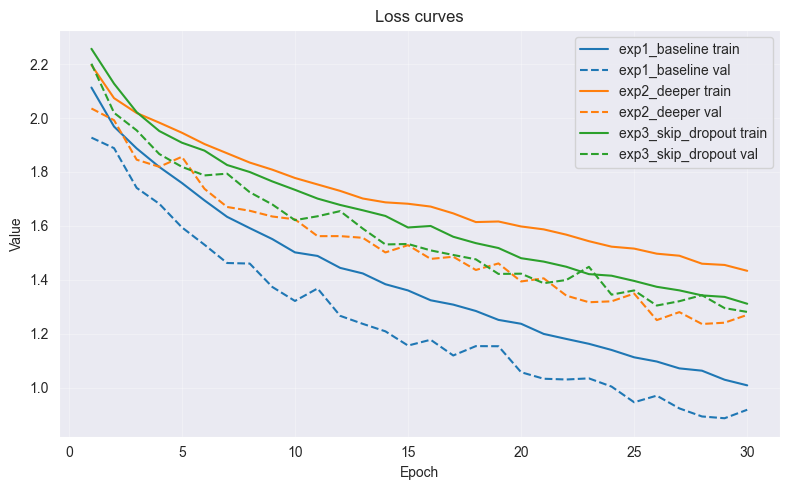

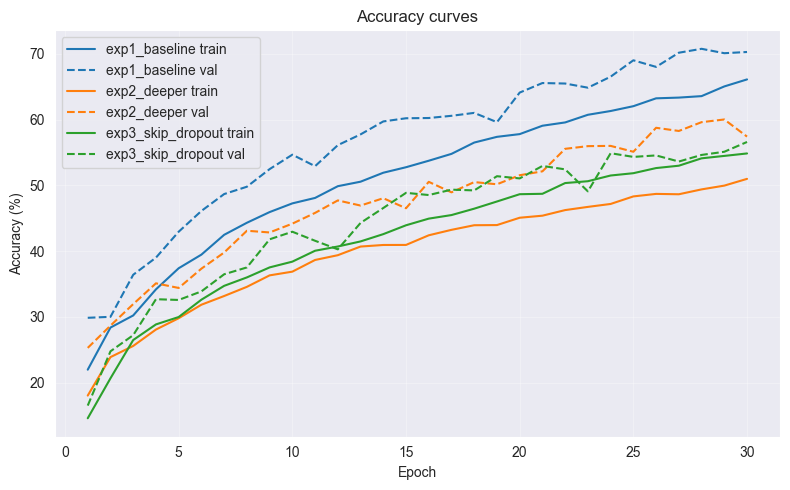

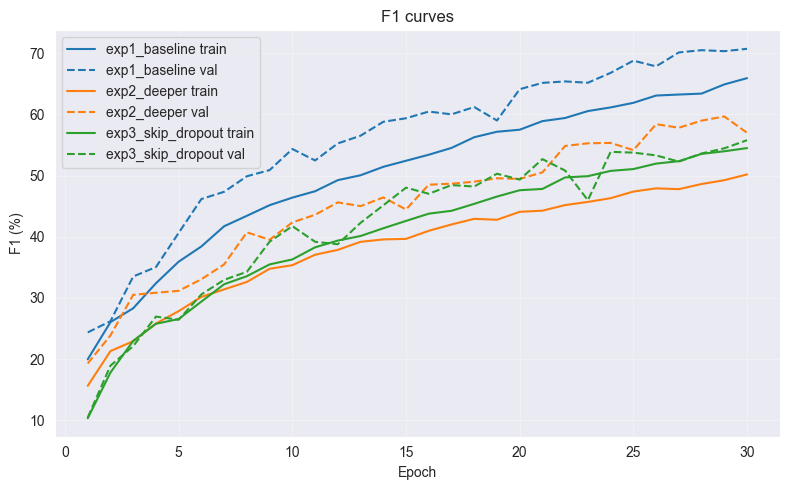

experiment  test_loss   test_acc  test_precision  test_recall  \
0      exp1_baseline   0.879975  69.903274       70.226460    69.993379   
1        exp2_deeper   1.256598  57.849702       57.811025    57.846217   
2  exp3_skip_dropout   1.306382  54.873512       57.302760    54.461743   

     test_f1  best_val_metric  
0  69.721792        70.785262  
1  57.376518        60.029773  
2  54.165093        56.605880

In [28]:
# Plot training history across experiments (solid=train, dashed=val per experiment)
metrics_to_plot = ["loss", "accuracy", "f1"]
color_map = plt.cm.get_cmap("tab10")
exp_names = list(experiment_results.keys())
colors = {name: color_map(i % 10) for i, name in enumerate(exp_names)}

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    for exp_name, res in experiment_results.items():
        color = colors[exp_name]
        train_curve = [m[metric] for m in res["history"]["train"]]
        val_curve = [m[metric] for m in res["history"]["val"]]
        epochs_range = range(1, len(train_curve) + 1)
        plt.plot(epochs_range, train_curve, label=f"{exp_name} train", color=color, linestyle="-")
        plt.plot(epochs_range, val_curve, label=f"{exp_name} val", color=color, linestyle="--")
    plt.xlabel('Epoch')
    ylabel = 'Value' if metric == 'loss' else f"{metric.capitalize()} (%)"
    plt.ylabel(ylabel)
    plt.title(f"{metric.capitalize()} curves")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Tabular summary of test metrics
rows = []
for exp_name, res in experiment_results.items():
    tm = res["test_metrics"]
    rows.append({
        "experiment": exp_name,
        "test_loss": tm["loss"],
        "test_acc": tm["accuracy"],
        "test_precision": tm["precision"],
        "test_recall": tm["recall"],
        "test_f1": tm["f1"],
        "best_val_metric": res.get("best_val_metric"),
    })
summary_df = pd.DataFrame(rows)
display(summary_df.sort_values(by="test_f1", ascending=False).reset_index(drop=True))


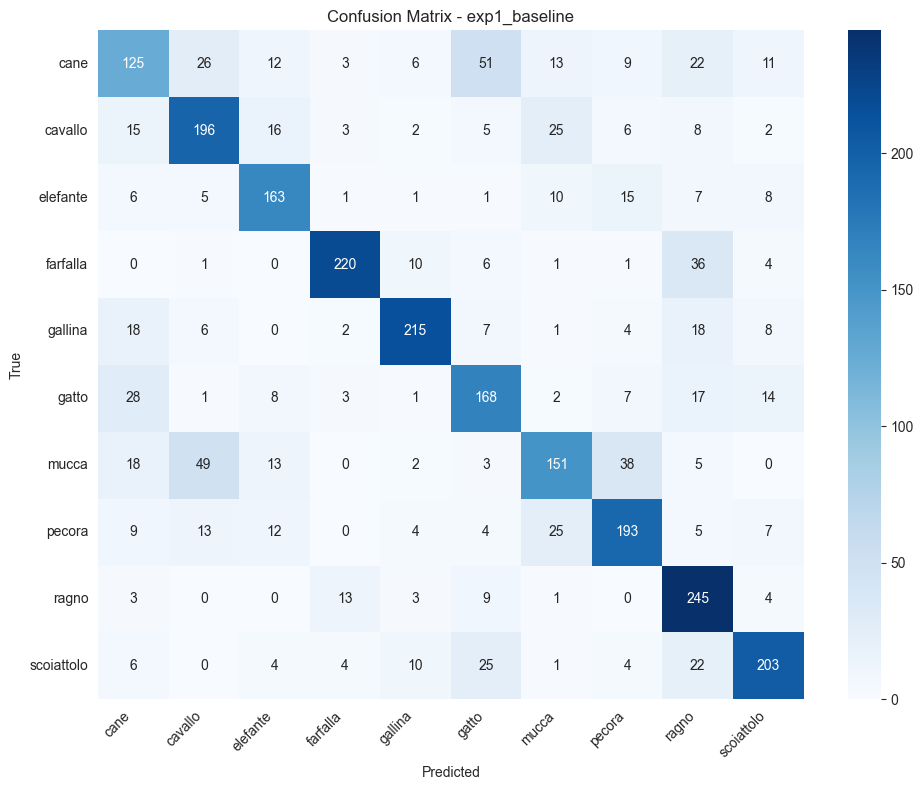

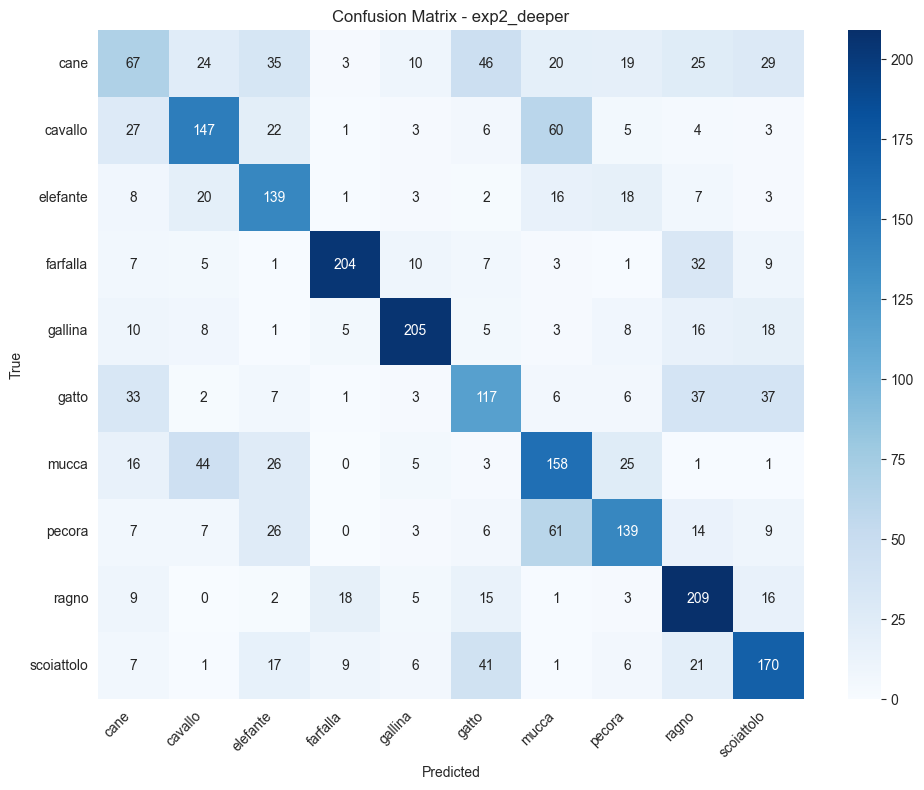

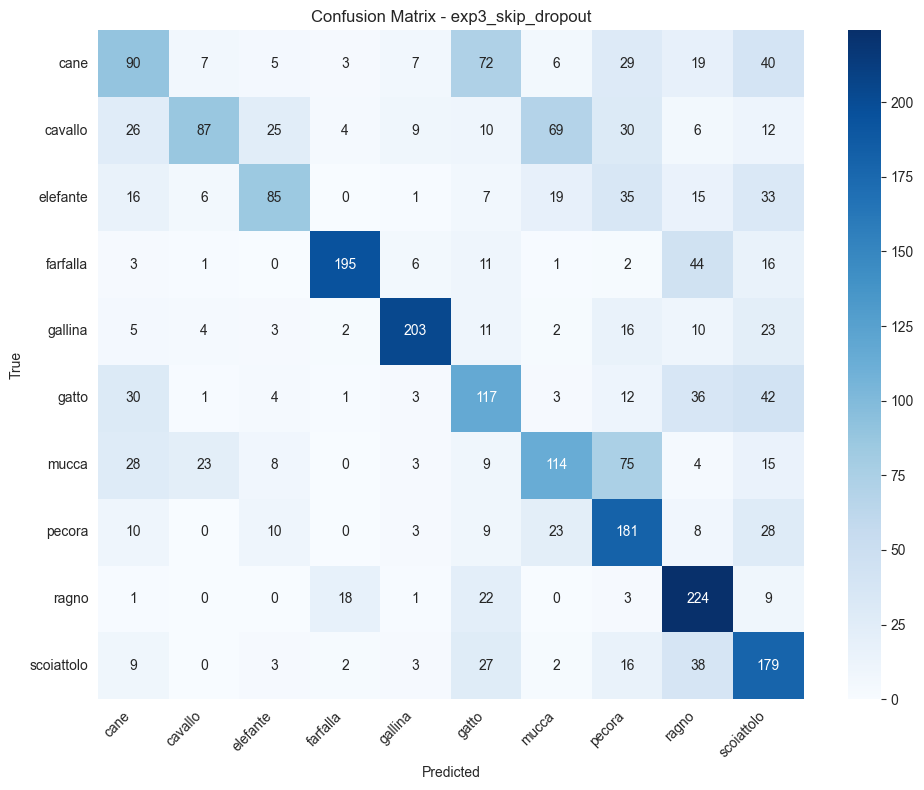

In [29]:
# Confusion matrices per experiment
import seaborn as sns

for exp_name, res in experiment_results.items():
    preds = res["test_preds"]
    labels = res["test_labels"]
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {exp_name}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()